https://ggodong.tistory.com/21

In [1]:
from keras import models, layers`
from keras.applications import VGG16
from keras import Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import tensorflow as tf


train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join('/home/gpulab/Dev/ImageTraining/Check_gender/Dataset/Train')
val_dir = os.path.join('/home/gpulab/Dev/ImageTraining/Check_gender/Dataset/Validation')
test_dir = os.path.join('/home/gpulab/Dev/ImageTraining/Check_gender/Dataset/Test')

In [16]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=64, target_size=(220, 200), color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=64, target_size=(220, 200), color_mode='rgb')

input_tensor = Input(shape=(220, 200, 3), dtype='float32', name='input')

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.


In [4]:
#pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(220, 200,3))
#pre_trained_vgg.trainable = False
# pre_trained_vgg.summary()



In [5]:
#다중 GPU 사용 모델 불러오기

#사용할 GPU 수 정의
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

strategy = tf.distribute.MirroredStrategy()
print('장치의 수: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():  
    additional_model = load_model('/home/gpulab/Dev/ImageTraining/Check_gender/pretrained_VGG_weight.hdf5')
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/home/gpulab/Dev/ImageTraining/Check_gender/pretrained_VGG_weight.hdf5', 
            monitor='loss', 
            mode='min', 
            save_best_only=True)
    additional_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
장치의 수: 1


In [4]:
import time
import tensorflow as tf
start = time.time()  # 시작 시간 저장

history = additional_model.fit(train_generator, 
            steps_per_epoch=math.ceil(train_generator.n / train_generator.batch_size),            epochs=1, 
            validation_data=val_generator, 
            validation_steps=math.ceil(val_generator.n / val_generator.batch_size), 
            callbacks=[checkpoint])

# 작업 코드
print("걸린시간 :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then br

In [2]:
# number of train & validation samples 
# print(train_generator.n)
# print(val_generator.n)
 
# number of train & val batch_size
# print(train_generator.batch_size)
# print(val_generator.batch_size)
 
 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

NameError: name 'history' is not defined

In [6]:
test_set = test_datagen.flow_from_directory(test_dir, target_size=(220, 200),batch_size=1, class_mode='binary')

Found 19999 images belonging to 2 classes.


In [8]:
output = additional_model.predict(test_set, steps=1)

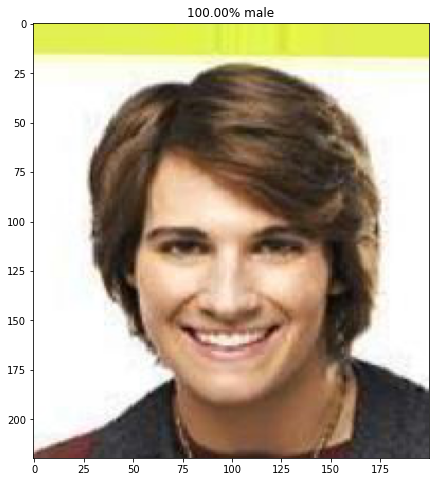

In [13]:
test_img = img_to_array(load_img(os.path.join('/home/gpulab/Dev/ImageTraining/Check_gender/Dataset/Test', '172108.jpg'), target_size=(220,200)))

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

pred = additional_model.predict(test_input)

plt.figure(figsize=(8,8))
if pred[0][1] > 0.9:
    plt.title('%.2f%% male' % (pred[0][1] * 100))
else:
    plt.title('%.2f%% female' % (pred[0][0] * 100))
plt.imshow(test_img.astype(np.uint8))
